In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Conv1D, \
MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D,Input,Concatenate,Merge, concatenate

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
PATH = Path("../data/")

In [4]:
scaler = joblib.load(PATH/'train_scaler_x.pkl')

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


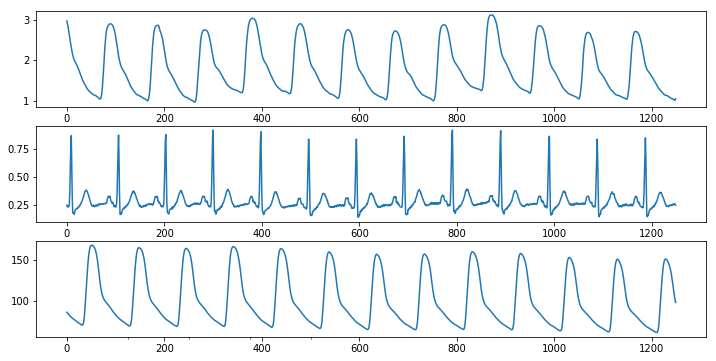

In [6]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(3,1,1)
ax.plot(dfX_Val[0,:1250])
ax = plt.subplot(3,1,2)
ax.plot(dfX_Val[0,1250:])
ax = plt.subplot(3,1,3)
ax.plot(dfY_Val[0,:])
ax.set_xticks(range(1,dfY_Val.shape[1]//2, 125), range(1,dfY_Val.shape[1]//2, 125))
plt.show()

In [7]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [8]:
#Normalize Y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T

In [9]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


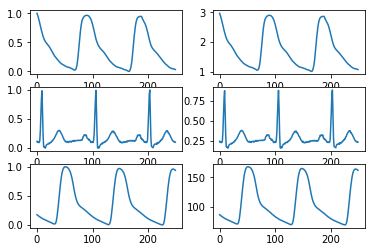

In [10]:
ax = plt.subplot(3,2,1)
ax.plot(valX_0_n[0,:])
ax = plt.subplot(3,2,2)
ax.plot(dfX_Val[0,ini:ini+dim])
ax = plt.subplot(3,2,3)
ax.plot(valX_1_n[0,:])
ax = plt.subplot(3,2,4)
ax.plot(dfX_Val[0,ini+ecg:ini+ecg+dim])
ax = plt.subplot(3,2,5)
ax.plot(valY_n[0,:])
ax = plt.subplot(3,2,6)
ax.plot(dfY_Val[0,ini:ini+dim])

plt.show()

In [12]:
trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [48]:
input_tensor_x = Input(shape=(dim, 1))
input_tensor_y = Input(shape=(dim, 1))

x = Conv1D(filters=64, kernel_size=32, activation='relu')(input_tensor_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv1D(filters=64, kernel_size=75, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

y = Conv1D(filters=64, kernel_size=32, activation='relu')(input_tensor_y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)

y = Conv1D(filters=64, kernel_size=75, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.2)(y)

merged = concatenate([x,y])
result = GlobalMaxPooling1D()(merged)
result = Dense(dim)(result)
result = BatchNormalization()(result)
result = Dropout(0.5)(result)
result = Dense(dim)(result)

model = Model([input_tensor_x, input_tensor_y], result)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 250, 1)       0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 250, 1)       0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 219, 64)      2112        input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 219, 64)      2112        input_18[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [52]:
# fit model
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mse')
history_prev = history
history = model.fit([np.expand_dims(trainX_n[:,:,0],2),np.expand_dims(trainX_n[:,:,1],2)], trainY_n, 
                     validation_data=([np.expand_dims(valX_n[:,:,0],2),np.expand_dims(valX_n[:,:,1],2)], valY_n), 
                     batch_size=64, epochs=20, verbose=1)

Train on 8126 samples, validate on 1016 samples
Epoch 1/20
8126/8126 [==============================] - 8s 979us/step - loss: 0.0663 - val_loss: 0.0767
Epoch 2/20
8126/8126 [==============================] - 5s 623us/step - loss: 0.0650 - val_loss: 0.0814
Epoch 3/20
8126/8126 [==============================] - 5s 623us/step - loss: 0.0645 - val_loss: 0.0729
Epoch 4/20
8126/8126 [==============================] - 5s 627us/step - loss: 0.0634 - val_loss: 0.0705
Epoch 5/20
8126/8126 [==============================] - 5s 624us/step - loss: 0.0626 - val_loss: 0.0720
Epoch 6/20
8126/8126 [==============================] - 5s 622us/step - loss: 0.0618 - val_loss: 0.0724
Epoch 7/20
8126/8126 [==============================] - 5s 623us/step - loss: 0.0614 - val_loss: 0.0731
Epoch 8/20
8126/8126 [==============================] - 5s 624us/step - loss: 0.0606 - val_loss: 0.0690
Epoch 9/20
8126/8126 [==============================] - 5s 623us/step - loss: 0.0602 - val_loss: 0.0711
Epoch 10/20
8126

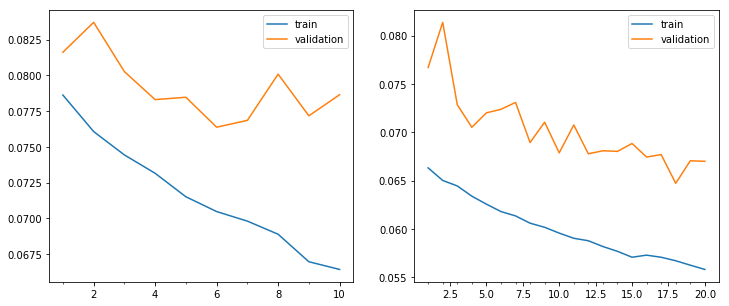

In [53]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [54]:
model.save_weights('conv1d_concat_1.h5')
with open('conv1d_concat_1.json', 'w') as f:
    f.write(model.to_json())

(250, 2)
(1, 250, 1)


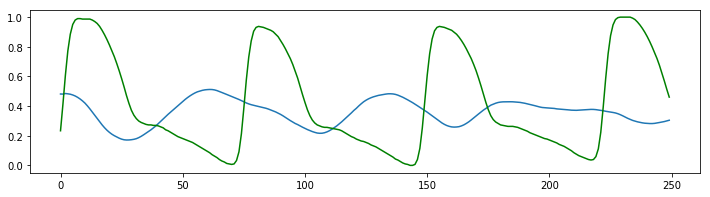

In [56]:
ix=1000
print(testX_n[ix].shape)
print(np.expand_dims(testX_n[ix,:,0].reshape(1,-1), axis=2).shape)

plt.figure(figsize=(12,3))
plt.plot(model.predict([np.expand_dims(trainX_n[ix,:,0].reshape(1,-1),2),np.expand_dims(trainX_n[ix,:,1].reshape(1,-1),2)]).T)
plt.plot(testY_n[ix,:].reshape(1,-1).T, c="g")
plt.show()